<a href="https://colab.research.google.com/github/harrizazham98/ImageStitching/blob/main/surf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall opencv-python -y
# downgrade OpenCV a bit since some none-free features are not avilable
!pip install opencv-contrib-python==3.4.2.17 --force-reinstall

Uninstalling opencv-python-4.1.2.30:
  Successfully uninstalled opencv-python-4.1.2.30
     |████████████████████████████████| 30.6MB 101kB/s 
     |████████████████████████████████| 15.7MB 195kB/s 
ERROR: imgaug 0.2.9 requires opencv-python, which is not installed.
ERROR: dopamine-rl 1.0.5 requires opencv-python>=3.4.1.15, which is not installed.
ERROR: albumentations 0.1.12 requires opencv-python, which is not installed.
ERROR: tensorflow 2.5.0 has requirement numpy~=1.19.2, but you'll have numpy 1.21.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Su

In [ ]:
import numpy as np
import imutils
import cv2
from google.colab import files
import matplotlib.pyplot as plt
from random import randrange

In [ ]:
def detectAndDescribe(image):
  # convert the image to grayscale
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  
  # check to see if we are using OpenCV 3.X
  # detect and extract features from the image
  surf = cv2.xfeatures2d.SURF_create()
  (kps, features) = surf.detectAndCompute(image, None)
  # convert the keypoints from KeyPoint objects to NumPy
  # arrays
  kps = np.float32([kp.pt for kp in kps])
  # return a tuple of keypoints and features
  return (kps, features)

In [ ]:
def matchKeypoints(kpsA, kpsB, featuresA, featuresB,
		ratio, reprojThresh):
		# compute the raw matches and initialize the list of actual
		# matches
	matcher = cv2.DescriptorMatcher_create("BruteForce")
	rawMatches = matcher.knnMatch(featuresA, featuresB, 2)
	matches = []

		# loop over the raw matches
	for m in rawMatches:
			# ensure the distance is within a certain ratio of each
			# other (i.e. Lowe's ratio test)
		if len(m) == 2 and m[0].distance < m[1].distance * ratio:
			matches.append((m[0].trainIdx, m[0].queryIdx))

		# computing a homography requires at least 4 matches
	if len(matches) > 4:
			# construct the two sets of points
		ptsA = np.float32([kpsA[i] for (_, i) in matches])
		ptsB = np.float32([kpsB[i] for (i, _) in matches])

			# compute the homography between the two sets of points
		(H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,
				reprojThresh)

			# return the matches along with the homograpy matrix
			# and status of each matched point
		return (matches, H, status)

		# otherwise, no homograpy could be computed
	return None

In [ ]:
def drawMatches(imageA, imageB, kpsA, kpsB, matches, status):
		# initialize the output visualization image
	(hA, wA) = imageA.shape[:2]
	(hB, wB) = imageB.shape[:2]
	vis = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")
	vis[0:hA, 0:wA] = imageA
	vis[0:hB, wA:] = imageB

		# loop over the matches
	for ((trainIdx, queryIdx), s) in zip(matches, status):
			# only process the match if the keypoint was successfully
			# matched
		if s == 1:
				# draw the match
			ptA = (int(kpsA[queryIdx][0]), int(kpsA[queryIdx][1]))
			ptB = (int(kpsB[trainIdx][0]) + wA, int(kpsB[trainIdx][1]))
			cv2.line(vis, ptA, ptB, (0, 255, 0), 1)

		# return the visualization
	return vis

In [ ]:
def stitch(images, ratio=0.75, reprojThresh=4.0,
		showMatches=False):
		# unpack the images, then detect keypoints and extract
		# local invariant descriptors from them
	(imageB, imageA) = images
	(kpsA, featuresA) = detectAndDescribe(imageA)
	(kpsB, featuresB) = detectAndDescribe(imageB)


		# match features between the two images
	M = matchKeypoints(kpsA, kpsB,
			featuresA, featuresB, ratio, reprojThresh)

		# if the match is None, then there aren't enough matched
		# keypoints to create a panorama
	if M is None:
			return None

		# otherwise, apply a perspective warp to stitch the images
		# together
	(matches, H, status) = M
	result = cv2.warpPerspective(imageA, H,
			(imageA.shape[1] + imageB.shape[1], imageA.shape[0]))
	result[0:imageB.shape[0], 0:imageB.shape[1]] = imageB

		# check to see if the keypoint matches should be visualized
	if showMatches:
			vis = drawMatches(imageA, imageB, kpsA, kpsB, matches,
				status)

			# return a tuple of the stitched image and the
			# visualization
			return (result, vis)

		# return the stitched image
	return result

In [ ]:
cv2.__version__

'3.4.2'

In [ ]:
uploaded1 = files.upload()

Saving left.JPG to left.JPG


In [ ]:
uploaded2 = files.upload()

Saving right.JPG to right.JPG


In [ ]:
imageA = cv2.imread("left.JPG")
imageB = cv2.imread("right.JPG")
imageA = imutils.resize(imageA, width=500)
imageB = imutils.resize(imageB, width=500)

In [ ]:
(result, vis) = stitch([imageA, imageB], showMatches=True)

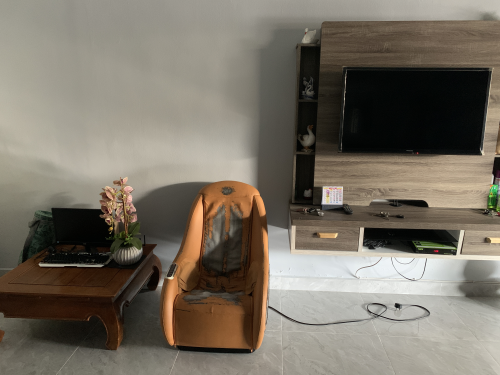

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(imageA)


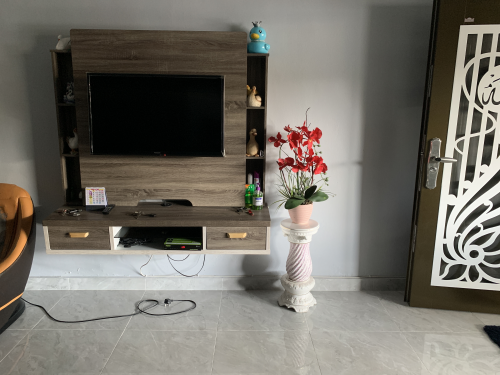

In [ ]:
cv2_imshow(imageB)

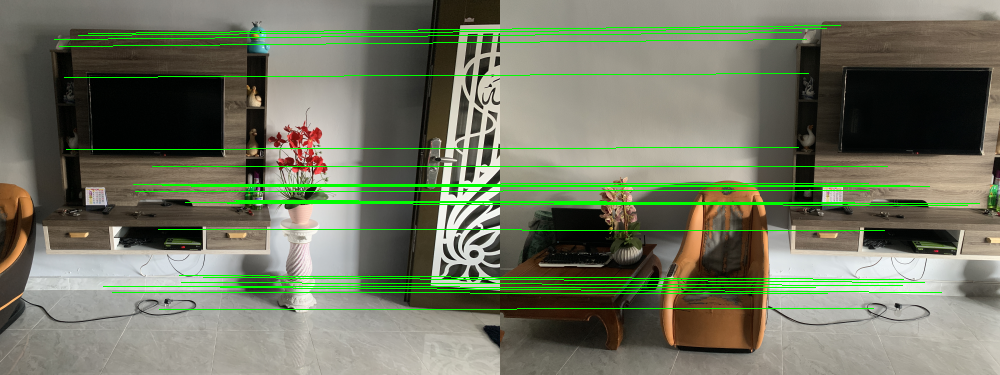

In [ ]:
cv2_imshow(vis)

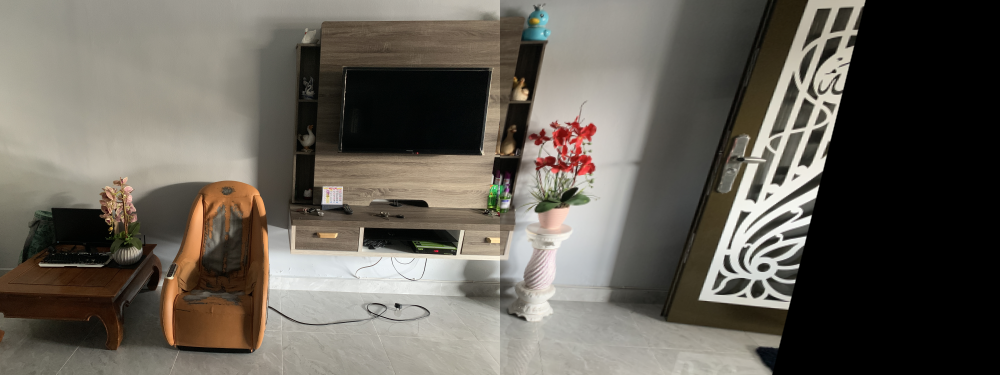

In [ ]:
cv2_imshow(result)

########################  ANALYSIS #################

In [ ]:
len(kpsA), len(kpsB), len(featuresA), len(featuresB)

NameError: ignored